In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [163]:
import autograd.numpy as anp
from autograd import grad, jacobian, hessian
from numpy.linalg import solve, norm

class NLPProblem:
    def __init__(self, f, h, g, epsilon=1e-6):
        self.f = f
        self.h = h
        self.g = g
        self.epsilon = epsilon
        self._grad_f = grad(f)
        self._jac_h = jacobian(h)
        self._jac_g = jacobian(g)

    def grad_f(self, x):
        return self._grad_f(x)

    def jac_h(self, x):
        h_val = self.h(x)
        n = len(x)
        m = len(h_val)
        if m == 0:
            return np.zeros((n, 0))
        J_raw = self._jac_h(x)  # shape (m, n)
        return J_raw.T  # shape (n, m)

    def jac_g(self, x):
        g_val = self.g(x)
        n = len(x)
        p = len(g_val)
        if p == 0:
            return np.zeros((n, 0))
        J_raw = self._jac_g(x)  # shape (p, n)
        return J_raw.T  # shape (n, p)

    def hess_lag(self, x, y, w):
        # Hessian of Lagrangian L(x) = f(x) - y^T h(x) - w^T g(x)
        def L(x_):
            return self.f(x_) - np.dot(y, self.h(x_)) - np.dot(w, self.g(x_))

        return hessian(L)(x)


class ArcSearchIP:
    def __init__(self, problem, x0):
        self.prob = problem
        self.x = x0
        m, p = len(problem.h(x0)), len(problem.g(x0))
        self.y = np.zeros(m)
        self.w = np.ones(p)
        self.s = np.maximum(problem.g(x0), 0.1)
        self.z = self.w.copy()
        self.hist = []

    def solve(self, maxiter=100):
        for _ in range(maxiter):
            if not self.step():
                break
        return (self.x, self.y, self.w, self.s, self.z)
    
    def step(self):
        # Precompute derivatives
        gradx, Jh, Jg = self.precompute()
        # 1) Eq. 6
        rx, rh, rg, rs, rz, kappa = self.k_components(gradx, Jh, Jg)
        if kappa < self.prob.epsilon: return False
        self.hist.append(kappa)
        # 2) Build KKT matrix (Eq. 15)
        A = self.build_kkt(Jh, Jg, gradx)
        # 3) Predictor-corrector RHS (Eq. 23)
        rhs1 = self.build_rhs1(rx, rh, rg, rs, rz, self.s, self.z)
        dv1 = solve(A, rhs1)
        x1, y1, w1, s1, z1 = self.split_dv(dv1, len(self.x), len(self.y), len(self.w))
        # 4) Corrector RHS (centering)
        rhs2 = self.build_rhs2(self.x, x1, y1, w1, s1, z1)
        dv2 = solve(A, rhs2)
        # 5) Update along arc (Eq. 19)
        self.arc_update(dv1, dv2, Jh, Jg)
        return True
    
    def precompute(self):
        x, y, w = self.x, self.y, self.w
        gradx = self.prob.grad_f(x)
        Jh = self.prob.jac_h(x)
        Jg = self.prob.jac_g(x)
        return gradx, Jh, Jg

    def k_components(self, gradx, Jh, Jg):
        x, y, w, s, z = self.x, self.y, self.w, self.s, self.z
        rx = gradx - Jh @ y - Jg @ w
        rh = self.prob.h(x)
        rg = self.prob.g(x) - s
        rs = w - z
        rz = z * s
        kappa = norm(np.concatenate([rx, rh, rg, rs, rz]))
        return rx, rh, rg, rs, rz, kappa

    def build_kkt(self, Jh, Jg, gradx):
        x, y, w, s, z = self.x, self.y, self.w, self.s, self.z
        n = len(x); m = len(y); p = len(w)
        H = self.prob.hess_lag(x, y, w)
        S = np.diag(s); Z = np.diag(z)
        # KKT block matrix (Eq. 15)
        return np.block([
            [H,               -Jh,             -Jg,             np.zeros((n,p)), np.zeros((n,p))],
            [Jh.T,            np.zeros((m,m)), np.zeros((m,p)), np.zeros((m,p)), np.zeros((m,p))],
            [Jg.T,            np.zeros((p,m)), np.zeros((p,p)), -np.eye(p),      np.zeros((p,p))],
            [np.zeros((p,n)), np.zeros((p,m)), np.eye(p),       np.zeros((p,p)), -np.eye(p)     ],
            [np.zeros((p,n)), np.zeros((p,m)), np.zeros((p,p)), Z,               S              ]
        ])

    def build_rhs1(self, rx, rh, rg, rs, rz, s, z):
        p = len(s)
        mu = (z @ s) / p
        sigma = 0.2
        # Predictor-corrector RHS (Eq. 15)
        return np.concatenate([rx, rh, rg, rs, rz - sigma*mu*np.ones(p)])

    def build_rhs2(self, x, x1, y1, w1, s1, z1):
        n, m, p = len(x), len(y1), len(w1)
        # Compute Hessians of each h_j and g_i at x
        Hh = [hessian(lambda v: self.prob.h(v)[j])(x) for j in range(m)]
        Hg = [hessian(lambda v: self.prob.g(v)[i])(x) for i in range(p)]
        # Eq.23 first block: 2*(sum_j y1[j]*Hh[j]*x1 + sum_i w1[i]*Hg[i]*x1)
        term1 = np.zeros(n)
        for j in range(m): term1 += 2 * y1[j] * (Hh[j] @ x1)
        for i in range(p): term1 += 2 * w1[i] * (Hg[i] @ x1)
        # Eq.23 second block (y): [-(x1^T Hh[j] x1)]_j
        term2 = np.array([-(x1 @ Hh[j] @ x1) for j in range(m)])
        # Eq.23 third block (w): [-(x1^T Hg[i] x1)]_i
        term3 = np.array([-(x1 @ Hg[i] @ x1) for i in range(p)])
        # Eq.23 fourth block (s): zeros of length p
        term4 = np.zeros(p)
        # Eq.23 fifth block (z): -2 * z1 * s1
        term5 = -2 * z1 * s1
        return np.concatenate([term1, term2, term3, term4, term5])
    

    def split_dv(self, dv, n, m, p):
        splits = [n, n+m, n+m+p, n+m+2*p]
        return np.split(dv, splits)

    def arc_update(self, dv1, dv2, Jh, Jg):
        x, y, w, s, z = self.x, self.y, self.w, self.s, self.z
        n = len(x); m = len(y); p = len(w)
        x1, y1, w1, s1, z1 = self.split_dv(dv1, n, m, p)
        dv2_x = dv2[:n]; dv2_w = dv2[n+m:n+m+p]
        alpha = self.max_step(x, w, s, z, x1, w1, s1)
        sin_a = np.sin(alpha)
        cos_a = np.cos(alpha)
        self.x = x - x1*sin_a + dv2_x*(1-cos_a)
        self.w = w - w1*sin_a + dv2_w*(1-cos_a)
        self.s = self.prob.g(self.x)
        self.z = np.copy(self.w)
        if m>0:
            b = Jh.T@(self.prob.grad_f(self.x) - Jg@self.w)
            self.y = solve(Jh.T@Jh, b)

    def max_step(self, x, w, s, z, x1, w1, s1):
        alpha_max = np.pi/2
        ratios = []
        for v, dv in [(w, w1), (s, s1)]:
            mask = dv < 0
            if np.any(mask):
                ratios.append(np.min(-v[mask]/dv[mask]))
        if ratios:
            alpha_max = min(alpha_max, np.min(ratios))
        return 0.995 * alpha_max


x*= [13.         20.00035202]
f(x*)= 27.000000000048274


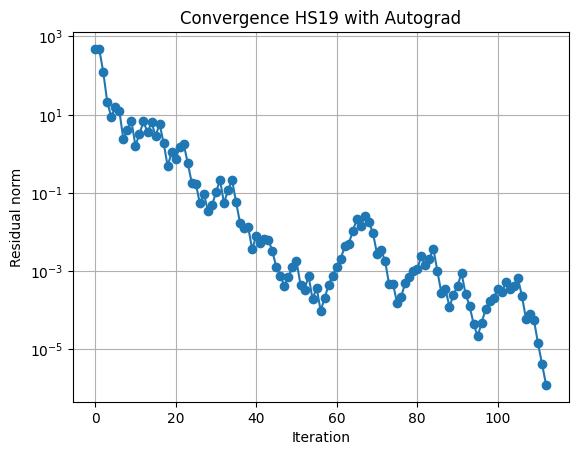

In [164]:
# HS19 with autograd
def f(x): return (x[0] - 10) ** 3 + (x[1] - 20) ** 3


def h(x): return anp.zeros(0)


def g(x): return anp.array([(x[0] - 5) ** 2 + (x[1] - 5) ** 2 - 100,
                            -((x[1] - 5) ** 2 + (x[0] - 6) ** 2) + 82.81,
                            x[0] - 13,  # x1 >= 13
                            100 - x[0],  # x1 <= 100
                            x[1],  # x2 >= 0
                            100 - x[1]])  # x2 <= 100


x0 = anp.array([15.0, 23])
prob = NLPProblem(f, h, g)
solver = ArcSearchIP(prob, x0)
x_opt, y_opt, w_opt, s_opt, z_opt = solver.solve(250)
print('x*=', x_opt)
print('f(x*)=', f(x_opt))
plt.semilogy(solver.hist, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Residual norm')
plt.title('Convergence HS19 with Autograd')
plt.grid(True)
plt.show()
